# Карасов Николай Дмитриевич

## Домашняя работа №3

Рассмотрим краевую задачу для PDE
$$
\Big(-\frac{\partial^2}{\partial x^2} - \frac{\partial^2}{\partial y^2} + e^{xy}\Big)u(x, y) = f(x, y),
$$

$$0 \leq x, y \leq 1,\ u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0.$$

Пусть $f$ выбрана такой, что
$$
u_0(x, y) = \sin\pi x \sin 2\pi y
$$
– решение задачи.

Для численного решения этого уравнения может использоваться метод конечно-разностной дискретизации. Разделим интервал $[0, 1]$ по обеим координатам на $N+1$ отрезков одинаковой длины $h = 1/(N+1)$. В каждой точке $(x_i, y_j) = (ih, jh), i, j = 1,\ldots, N$ построим конечно-разностные аппроксимации вторых производных:

$$
-\frac{\partial^2}{\partial x^2}(x_i, yj) \approx -\frac{[u(x{i-1}, y_j) - 2u(x_i, yj) + u(x{i+1}, y_j)]}{h^2}
$$
$$
-\frac{\partial^2}{\partial y^2}(x_i, y_j) \approx -\frac{[u(xi, y{j-1}) - 2u(x_i, y_j) + u(xi, y{j+1})]}{h^2}
$$
Элементы СЛАУ
$$
A\cdot \overrightarrow u = \overrightarrow f,
$$
матрица и вектора-функции, записывается в терминах единого индекса $k = i + (j-1)N,\ k = 1, \ldots, N^2$. $(\overrightarrow u)_k = u(x_i, y_j),\ (\overrightarrow f)_k = f(x_i, yj)$.

Ненулевые элементы $A{kk'}$ матрицы определяются следующим образом:

$$
A_{kk'} = 4/h^2 + e^{x_iy_j},\ i = i',\ j = j'
$$

$$
A{kk'} = -1/h^2,\ |i - i'| = 1,\ j = j'
$$

$$
A_{kk'} = -1/h^2,\ i = i',\ |j - j'| = 1
$$

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import scipy
import scipy.optimize

from scipy.sparse import csr_matrix
from typing import Tuple, NoReturn, List

In [2]:
def honest_solution(x: float, y: float) -> float:
    return np.sin(np.pi * x) * np.sin(2 * np.pi * y)

In [3]:
def f_value(x: float, y: float) -> float:
    return honest_solution(x, y) * (5 * np.pi ** 2 + np.exp(x * y))

Построим матрицу `A`.

In [4]:
def build_matrix_A(N: int) -> Tuple:
    h = 1.0 / (N + 1)
    points = [i / (N + 1) for i in range(1, N + 1)]
    
    A = np.zeros((N ** 2, N ** 2))
    b = np.zeros(N ** 2)
    
    u_honest = np.zeros(N ** 2)
    
    val = -1.0 / h ** 2
    
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            k = i + (j - 1) * N
            
            if A[k - 1][k - 1] == 0:
                A[k - 1][k - 1] = 4.0 / h ** 2 + np.exp(points[i - 1] * points[j-1])
                
            if b[k - 1] == 0:
                b[k - 1] = f_value(points[i - 1], points[j - 1])
                
            if u_honest[k - 1] == 0:
                u_honest[k - 1] = honest_solution(points[i - 1], points[j - 1])

            if i > 1:
                A[k - 1][i + (j - 1) * N - 2] = val
            if i < N:
                A[k - 1][i + (j - 1) * N] = val

            if j > 1:
                A[k - 1][i + (j - 2) * N - 1] = val
            if j < N:
                A[k - 1][i + j * N - 1] = val

                
    return A, b, u_honest

Реализуем метод `sor`.

In [5]:
def sor(N: int, omega: float, A: np.ndarray = None, b: np.ndarray = None,
        u_honest: np.ndarray = None, max_iters: int = 100) -> Tuple:  
    if A is None:
        A, b, u_honest = build_matrix_A(N)

    u_1 = np.random.random(N ** 2)

    history = []

    for _ in range(max_iters):       
        u_0 = np.copy(u_1)
        for i in range(N ** 2):
            
            t_1 = A[i, :i] @ u_1[:i]
            t_2 = A[i, i + 1:] @ u_0[i + 1:]

            u_1[i] = u_0[i] * (1 - omega) + omega / A[i][i] * (b[i] - t_1 - t_2)
            
        history.append(np.max(np.abs(u_1 - u_honest)))
        
        if np.linalg.norm(u_1 - u_0) < 1e-6:
            break

    return u_1, history

In [6]:
def plot_error_with_n(max_iters: int) -> Tuple:
    N_grid = [10, 20, 50, 100]
    w_grid = [1.0, 1.3, 1.6, 1.8, 1.9]
    
    errors = []

    for N in N_grid:
        
        A, b, u_honest = build_matrix_A(N)
        
        plt.figure(figsize=(16,8))
        
        cur_err = []

        for w in w_grid:
            _, error = sor(N, w, A, b, u_honest, max_iters=max_iters)
            cur_err.append(error)
            x = np.arange(len(error))

            plt.plot (x, error, label = f'w={w}', linewidth=3)
        errors.append(cur_err)

        plt.xlabel('Номер итерации', fontsize=15)
        plt.ylabel('Погрешность', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=12)
        plt.grid()
        plt.legend(fontsize=15)
        plt.title(f'Зависимость погрешности решения методом SOR (N={N}) от номера итерации', fontsize=15)
        plt.show()
        
    return N_grid, w_grid, errors

Построим графики вида зависимость ошибки от номера итерации для различных `N`.

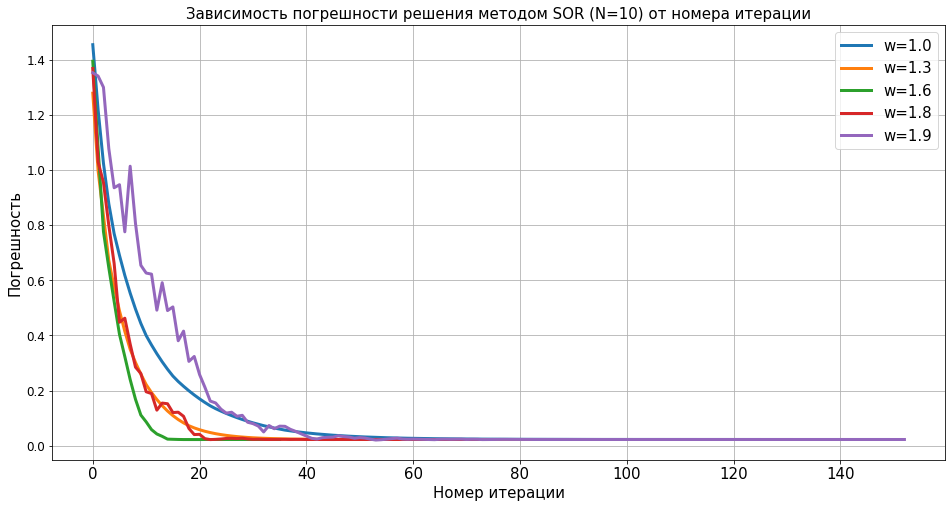

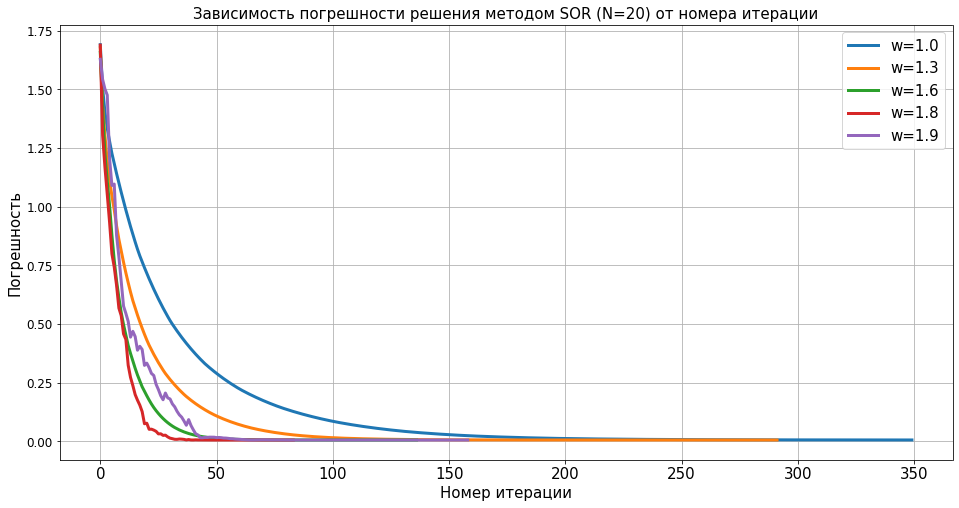

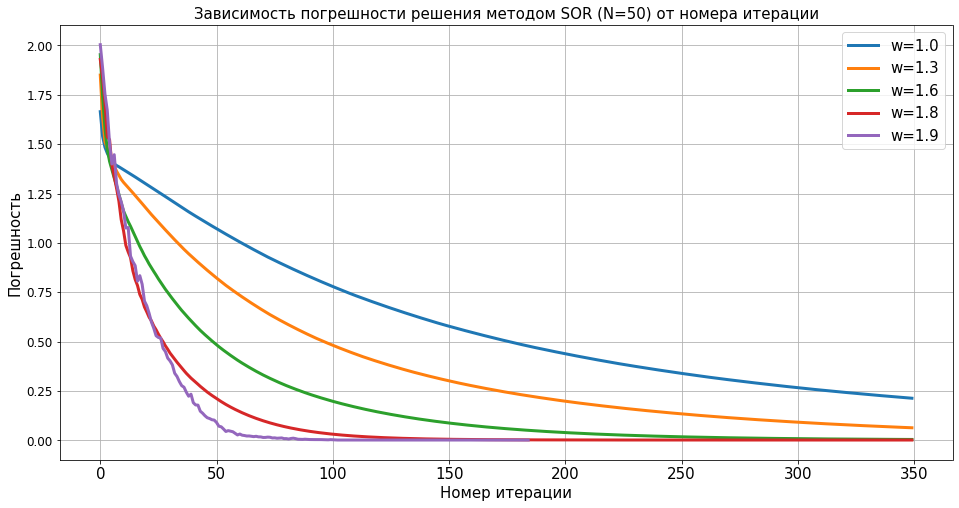

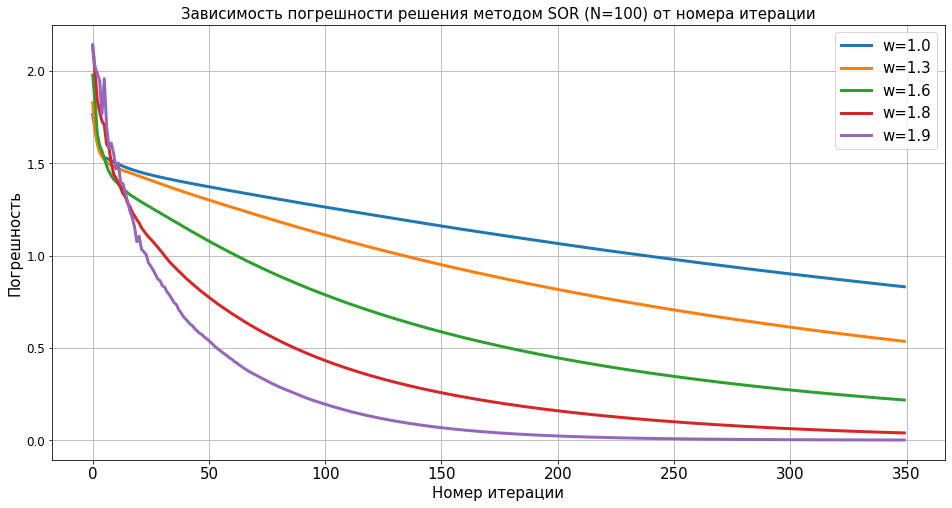

CPU times: user 4min 30s, sys: 1.69 s, total: 4min 32s
Wall time: 4min 32s


In [7]:
%%time
N_grid, w_grid, errors = plot_error_with_n(350)

При разных значениях параметра `omega` методу требуется разное число итераций для сходимости с приведенным критерием остановки. Поэтому варьировать параметр `omega` очень полезно.

In [8]:
def plot_log_error_with_n(N_grid: List, w_grid: List, errors: List) -> NoReturn:
    
    for i, error in enumerate(errors):
        plt.figure(figsize=(16,8))
        
        for j, cur_err in enumerate(error):
            
            x = np.arange(len(cur_err))

            plt.plot (x, np.log10(cur_err), label = f'w={w_grid[j]}', linewidth=3)
        
        plt.xlabel('Номер итерации', fontsize=15)
        plt.ylabel('Погрешность', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=12)
        plt.grid()
        plt.legend(fontsize=15)
        plt.title(f'Зависимость погрешности решения методом SOR (N={N_grid[i]}) от номера итерации', fontsize=15)
        plt.show()

Посмотрим на те же графики, только уже не просто на ошибку, а на $\log_{10}(\mathrm{error})$.

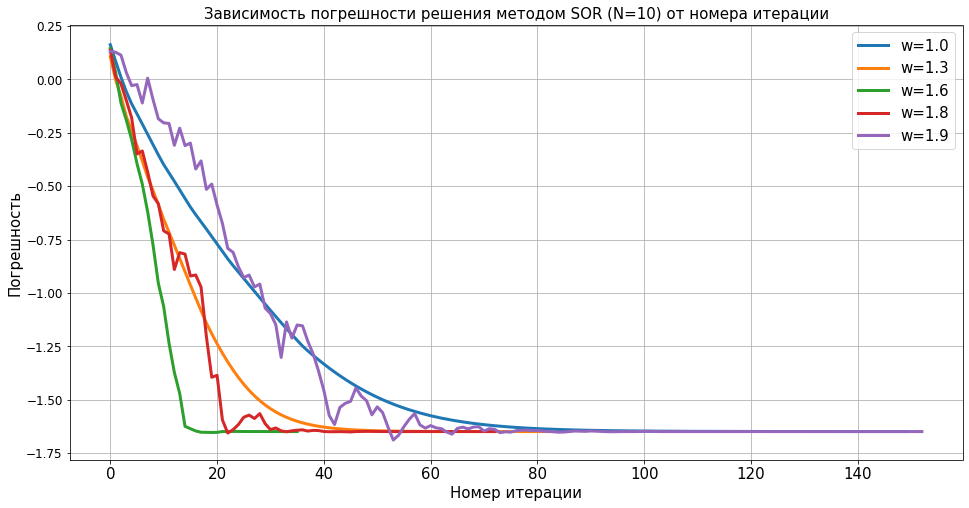

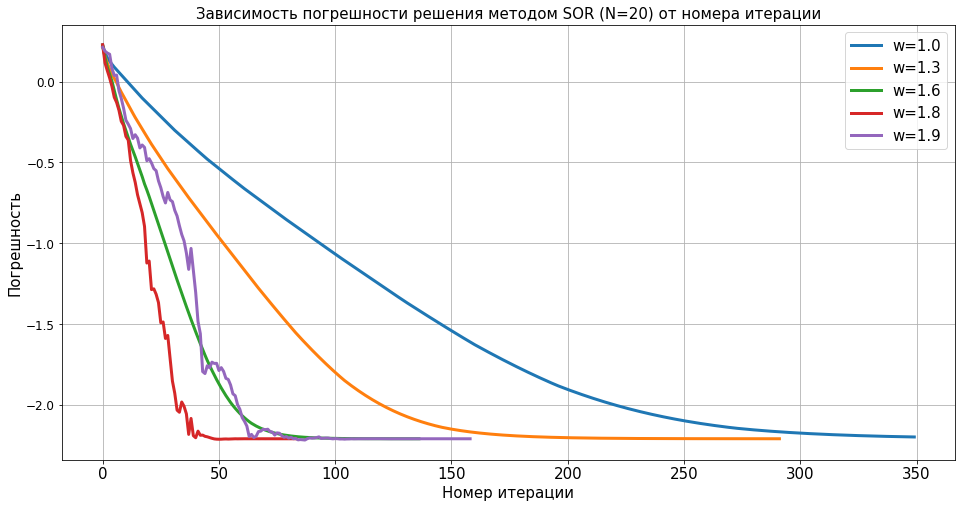

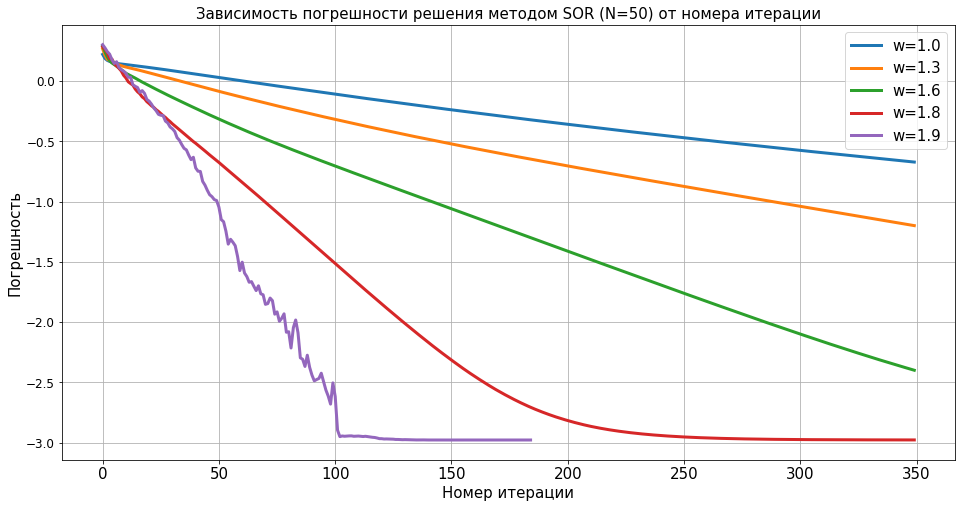

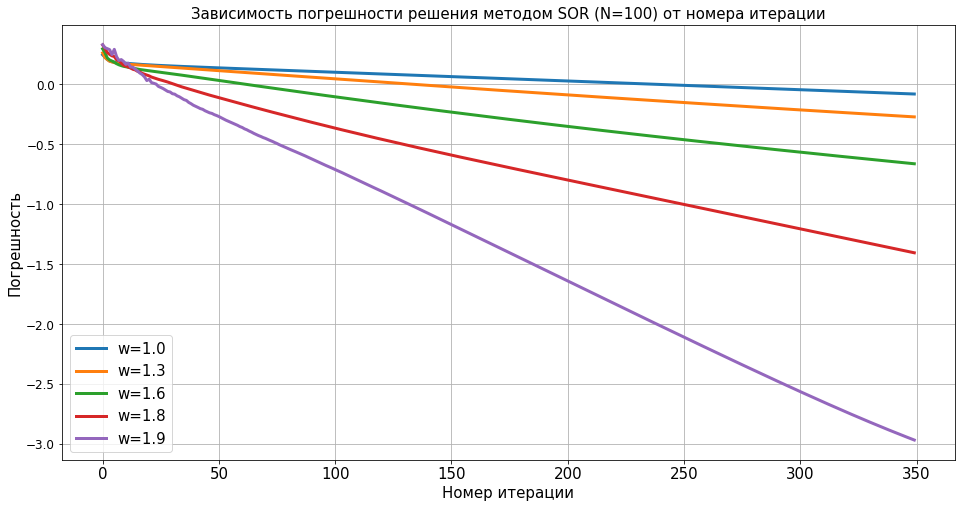

CPU times: user 1.17 s, sys: 159 ms, total: 1.33 s
Wall time: 1.33 s


In [9]:
%%time
plot_log_error_with_n(N_grid, w_grid, errors)

In [10]:
def plot_optimal_w() -> NoReturn:
    x = [10, 20, 30, 50, 60]
    res = []

    for i, val in enumerate(x):
        res.append(scipy.optimize.minimize_scalar(lambda w: len(sor(val, w, max_iters=310)[1]), method='bounded', bounds=(1, 2)).x)

    plt.figure(figsize=(16,8))
    plt.plot(x, np.array(res))
    plt.xlabel('N', fontsize=15)
    plt.ylabel('Оптимальное значение параметра Omega', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.title('Оптимальное значение параметра Omega для разных N (оптимальность в смысле числа итераций)', fontsize=15)
    plt.show()

Найдем оптимальное значение параметра `omega` с точки зрения количества выполненных итераций. 

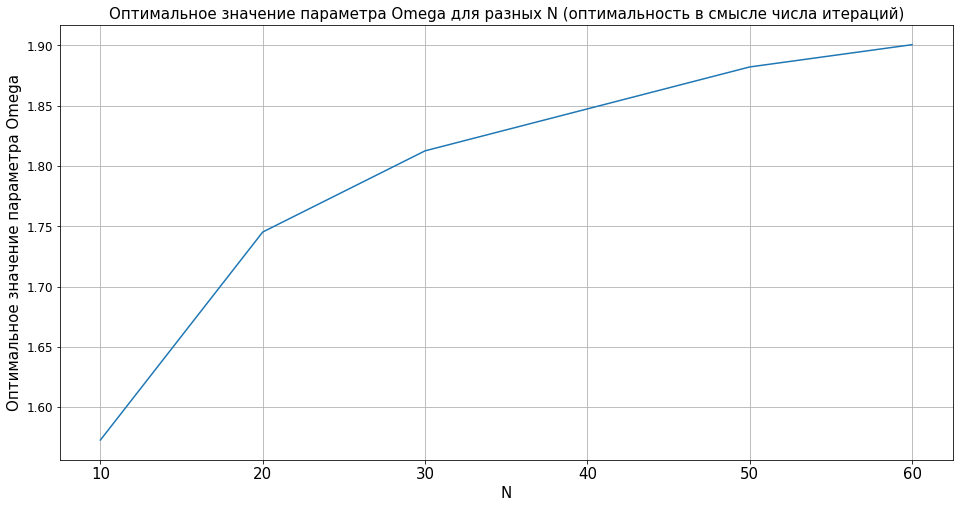

CPU times: user 4min 25s, sys: 839 ms, total: 4min 26s
Wall time: 4min 27s


In [11]:
%%time
plot_optimal_w()

Выше попробовали найти оптимальное `omega` в плане числа итераций SOR-метода. Можно заметить, что с ростом `N` оно стремится к $2$.

## Sparse matrix

Можно немного модифицировать реализованные функции, чтобы не хранить матрицу целиком, а хранить именно sparse-матрицу.

In [12]:
def build_sparse_matrix_A(N: int) -> Tuple:
    h = 1.0 / (N + 1)
    points = [i / (N + 1) for i in range(1, N + 1)]
    
    b = np.zeros(N ** 2)
    
    data = []
    row = []
    col = []
    
    done = np.zeros(N ** 2)
    
    u_honest = np.zeros(N ** 2)
    
    val = -1.0 / h ** 2
    
    for i in range(1, N + 1):
        for j in range(1, N + 1):
            k = i + (j - 1) * N
            
            if done[k - 1] == 0:
                done[k - 1] = 1
                data.append(4.0 / h ** 2 + np.exp(points[i - 1] * points[j-1]))
                row.append(k-1)
                col.append(k-1)
                
            if b[k - 1] == 0:
                b[k - 1] = f_value(points[i - 1], points[j - 1])
                
                
            if u_honest[k - 1] == 0:
                u_honest[k - 1] = honest_solution(points[i - 1], points[j - 1])

            if i > 1:
                data.append(val)
                row.append(k-1)
                col.append(i + (j - 1) * N - 2)
            if i < N:
                data.append(val)
                row.append(k-1)
                col.append(i + (j - 1) * N)

            if j > 1:
                data.append(val)
                row.append(k-1)
                col.append(i + (j - 2) * N - 1)
            if j < N:
                data.append(val)
                row.append(k-1)
                col.append(i + j * N - 1)

                
    return csr_matrix((data,(row, col)), (N**2, N**2)), b, u_honest

In [13]:
def sor_sparse(N: int, omega: float, A: np.ndarray = None,
               b: np.ndarray = None, u_honest: np.ndarray = None, max_iters: int = 100) -> Tuple:  
    if A is None:
        A, b, u_honest = build_sparse_matrix_A(N)

    u_1 = np.random.random(N ** 2)

    history = []

    for _ in range(max_iters):       
        u_0 = np.copy(u_1)
        for i in range(N ** 2):
            
            t_1 = A[i, :i] @ u_1[:i]
            t_2 = A[i, i + 1:] @ u_0[i + 1:]

            u_1[i] = u_0[i] * (1 - omega) + omega / A[i, i] * (b[i] - t_1 - t_2)
            
        history.append(np.max(np.abs(u_1 - u_honest)))
        
        if np.linalg.norm(u_1 - u_0) < 1e-6:
            break

    return u_1, history